## Análise dos Salários da Unidade de San Francisco  

**Contexto:**  
Nesse projeto, tive a oportunidade de apresentar minha expertise ao CEO da **Hidden Analysis**, que me propôs extrair insights da Agência de San Francisco. Ele deixou claro que precisava desse projeto até amanhã de manhã. Caso eu me sinta pressionado, ele sugeriu que posso convocar um analista do RH para ajudar.  

### Exigências dele:  

1. Qual foi a evolução do salário médio ao longo dos anos (TotalPay e TotalPayBenefits).  
2. Quantos funcionários tivemos ao longo dos anos.  
3. Qual foi a maior média salarial registrada e em que ano isso ocorreu, com base no cargo?  
4. Qual foi a evolução do total gasto com salário ao longo dos anos (TotalPayBenefits).  
5. Prever, nesse ritmo, a evolução dos salários médios nos próximos 5 anos.

--- 


chat https://chatgpt.com/c/6741f631-b448-8011-9796-5df9d3481759

Importando a base e entendimento do desafio inicial

- Para extrair minha base com os salarios vou usar a integração de Python com sql e transforma em um DataFramer ai sim começa a limpesa.

In [1]:
import pyodbc
import pandas as pd

import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
from matplotlib.ticker import FuncFormatter

#paleta de cores
cores = plt.get_cmap('Pastel2').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
#CONEXAO
bancoDados = ("Driver={SQLite3 ODBC Driver};Server=localhost;Database=./salarios.sqlite")
conexao = pyodbc.connect(bancoDados)
cursor = conexao.cursor()

comando = """ 
SELECT * FROM Salaries
"""
cursor.execute(comando)
valores = cursor.fetchall()

descricao = cursor.description
descricao[0]

('Id', int, None, 10, 10, 0, True)

- Notei que o retorno do primeiro item foi uma tupla e seu primeiro valor e o nome da coluna.

In [3]:
colunas = [tupla[0] for tupla in descricao]#criando uma lista de colunas

tabela = pd.DataFrame.from_records(valores, columns= colunas)
tabela.to_csv('tabela_salarios.csv',index=False)#salvar tabela em .csv

display(tabela.head())
display(tabela.shape)
cursor.close()
conexao.close()


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,,San Francisco,
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,,San Francisco,
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,,San Francisco,
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,,San Francisco,
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,,San Francisco,


(148654, 13)

### Inicio da Análise de Dados

- Preciso lembrar que essa análise é direcionada para Agência de São Francisco.
- Então desdo inicio tenho que filtrar minha analise só valores da coluna Agency for igual 'San Francisco'.

In [4]:
# O argumento 'low_memory = False' é usado para evitar o consumo excessivo de memória para arquivos grandes
tabela_salarios = pd.read_csv('tabela_salarios.csv',low_memory=False).loc[tabela['Agency'] == 'San Francisco', :]
display(tabela_salarios.head())

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


Tabela que mostra valores *Nulos*

In [5]:
tabela_nan = tabela_salarios.isnull().groupby('Id')[tabela_salarios.columns].sum()
display(tabela_nan)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
Id,,,,,,,,,,,,,
False,0,0,0,609,4,4,36163,0,0,0,148654,0,110535


Notei que existe varios NaN nesta tabela como que o foco inicial sera na coluna **TotalPay , TotalPayBenefits, Year e Id** e todos eles estão totalmente preenchidos não irei limpar essa tabela ainda quero usar esses valores brutos

In [6]:
def formatacao(valor):
    return 'R${:_.2f}'.format(valor).replace('.',',').replace('_','.')

##### 1. Qual foi a evolução do salário médio ao longo dos anos


,TotalPay,TotalPayBenefits
Year,,
2011,"R$71.744,10","R$71.744,10"
2012,"R$74.113,26","R$100.553,23"
2013,"R$77.611,44","R$101.440,52"
2014,"R$75.463,92","R$100.250,92"


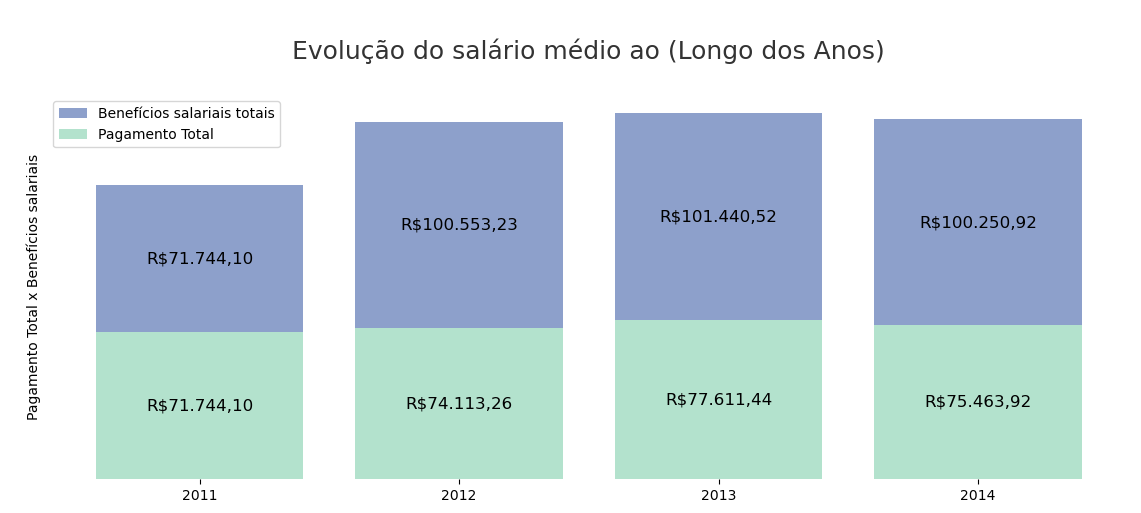

In [7]:
tabela_media = tabela.groupby('Year')[['TotalPay','TotalPayBenefits']].mean()

year = tabela_media.index.values
pagamento_total = tabela_media['TotalPay'].values
beneficios_salariais_totais = tabela_media['TotalPayBenefits'].values

paletas = plt.get_cmap('Set2').colors# pegar paleta de cor nova
fig, ax = plt.subplots(figsize=(14,5))

# Barras de benefícios salariais totais (empilhadas)
barras_beneficios = ax.bar(year,beneficios_salariais_totais,label = 'Benefícios salariais totais',bottom = pagamento_total,color  = paletas[2])
plt.bar_label(barras_beneficios,
              labels=[formatacao(v) for v in beneficios_salariais_totais],
              label_type='center',
              fontsize=12,
              color='black')

# Barras de pagamento total
barras_pagamento = ax.bar(year,pagamento_total,label='Pagamento Total')
plt.bar_label(barras_pagamento,
              labels=[formatacao(v) for v in pagamento_total],
              label_type='center',
              fontsize=12,
              color='black')



ax.set_title('\nEvolução do salário médio ao (Longo dos Anos)\n',fontsize=18,alpha=0.8)
ax.set_ylabel('\nPagamento Total x Benefícios salariais')
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])
ax.legend()
ax.set_frame_on(False)

# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_media['TotalPay'] = tabela_media['TotalPay'].apply(formatacao)
tabela_media['TotalPayBenefits'] = tabela_media['TotalPayBenefits'].apply(formatacao)
display(tabela_media)

plt.show()

* **Crescimento:** Observa-se um crescimento consistente nos salários médios ao longo dos anos analisados, tanto no que se refere ao pagamento base quanto aos benefícios. Isso indica uma tendência positiva na remuneração dos colaboradores.


##### 2. Quantos funcionários tivemos ao longo dos anos

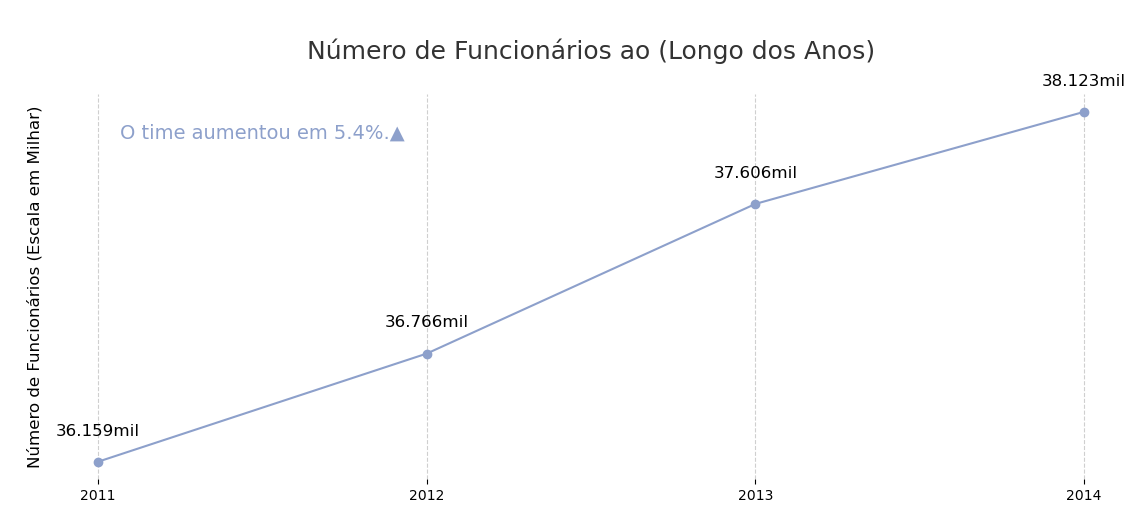

In [8]:
tabela_funcionarios = tabela.groupby('Year')[['Id']].count()
tabela_funcionarios = tabela_funcionarios.rename(columns={'Id':'Funcionarios'})
funcionarios = tabela_funcionarios['Funcionarios'].values

# Calculando o valor 
crescimento = (funcionarios[-1] - funcionarios[0]) / funcionarios[0]

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(year, funcionarios, marker='o', color=paletas[2], label="Funcionários")

# Adicionando rótulos diretamente nos pontos
for x, y in zip(year, funcionarios):
    ax.text(x, y + 150, f"{y:,}mil".replace(',','.'), ha='center', fontsize=12,color='black')

# Configurações do grafico
ax.set_title("\nNúmero de Funcionários ao (Longo dos Anos)\n", fontsize=18,alpha=0.8)

# Dividi os valores de x com year[len(year)//4] - 0.5
# Ajustei a altura de y com max(funcionarios) - 150

ax.text(year[len(year)//4] - 0.5, max(funcionarios) - 150,"O time aumentou em {:.1%}.▲".format(crescimento),fontsize=14,color=paletas[2],ha='center')
ax.set_ylabel("\nNúmero de Funcionários (Escala em Milhar)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])

# Aplica formatação personalizada às colunas de médias no DataFrame.
# tabela_funcionarios['Funcionarios'] = tabela_funcionarios['Funcionarios'].apply('{:,.0f}'.format)
# display(tabela_funcionarios)

plt.show()


* **Aumento no número de funcionários:** O número de funcionários também apresentou um crescimento significativo no período de 4 anos, o que pode ter influenciado o aumento do gasto total com salários.

##### 3. Qual foi a maior média salarial registrada e em que ano isso ocorreu, com base no cargo?

,Ano,CargoTotalPay,MaiorMediaTP,CargoTotalPayBenefits,MaiorMediaTPB
0,2011,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,"R$399.211,28",GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,"R$399.211,28"
1,2012,Chief of Police,"R$321.552,11",Chief of Police,"R$391.362,30"
2,2013,Chief of Police,"R$339.282,07",Chief of Police,"R$425.815,28"
3,2014,Chief Investment Officer,"R$339.653,70",Chief Investment Officer,"R$436.224,36"


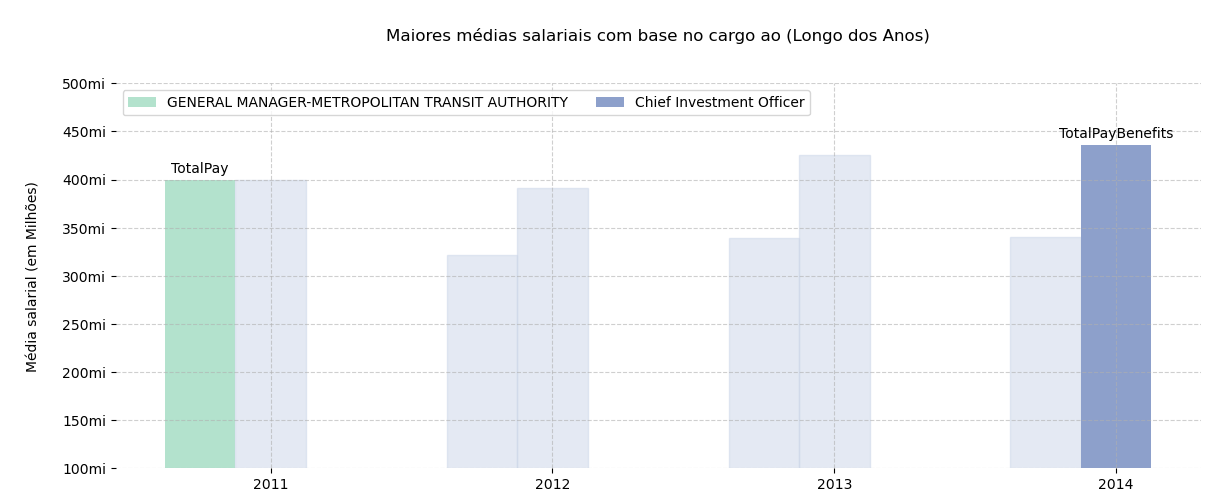

In [9]:
# Copia a tabela original para não alterar os dados originais.
tabela_maior_media = tabela.copy()

# Inicializa uma lista para armazenar os resultados calculados para cada ano.
tupla_armazenar = []

# Loop para processar cada ano único na tabela.
for coluna in tabela_maior_media['Year'].unique():
    # Filtra a tabela para incluir apenas os dados do ano atual.
    tabela_anos = tabela_maior_media[tabela_maior_media['Year'] == coluna]
    
    # Agrupa os dados por cargo ('JobTitle') e calcula a média de 'TotalPay' e 'TotalPayBenefits'.
    tabela_anos = tabela_anos.groupby('JobTitle')[['TotalPay', 'TotalPayBenefits']].mean()

    # Identifica o cargo com maior média de 'TotalPay' e 'TotalPayBenefits' e seus valores.
    tupla_armazenar.append((
        coluna,                                  # Ano
        tabela_anos['TotalPay'].idxmax(),       # Cargo com maior média em TotalPay
        tabela_anos['TotalPay'].max(),          # Maior média em TotalPay
        tabela_anos['TotalPayBenefits'].idxmax(),  # Cargo com maior média em TotalPayBenefits
        tabela_anos['TotalPayBenefits'].max()   # Maior média em TotalPayBenefits
    ))

# Cria um DataFrame a partir da lista armazenada com colunas nomeadas.
tabela_maior_media = pd.DataFrame(
    tupla_armazenar, 
    columns=['Ano', 'CargoTotalPay', 'MaiorMediaTP', 'CargoTotalPayBenefits', 'MaiorMediaTPB']
)

# Extrai as colunas de interesse em arrays separados para uso no gráfico.
pagamento_total = tabela_maior_media['MaiorMediaTP'].values
beneficios_salariais_totais = tabela_maior_media['MaiorMediaTPB'].values
cargos = tabela_maior_media['CargoTotalPay'].values
year = tabela_maior_media['Ano'].values

# Cria um dicionário para armazenar as médias salariais e de benefícios.
penguin_means = {
    'TotalPay': pagamento_total,
    'TotalPayBenefits': beneficios_salariais_totais,
}

x = np.arange(len(year))  # Posições no eixo X
largura = 0.25           # Largura das barras
multiplica = 0           # Multiplicador para calcular o deslocamento das barras

# Rótulos para os maiores valores em cada categoria.
rotulos_pt = [list(penguin_means.keys())[0] if valor == max(pagamento_total) else '' for valor in pagamento_total]
rotulos_tpb = [list(penguin_means.keys())[1] if valor == max(beneficios_salariais_totais) else '' for valor in beneficios_salariais_totais]

fig, ax = plt.subplots(figsize=(14, 5))

# Loop para criar as barras para cada categoria ('TotalPay' e 'TotalPayBenefits').
for chave, valor in penguin_means.items():
    offset = largura * multiplica  # Calcula o deslocamento da barra com base no índice.
    
    if chave == 'TotalPay':
        # Adiciona as barras para 'TotalPay' com uma leve diferença na altura (+150).
        rects = ax.bar(
            x + offset, valor + 150, largura, 
            label=cargos[tabela_maior_media['MaiorMediaTP'].idxmax()]
        )
        ax.bar_label(rects, padding=3, labels=rotulos_pt)  # Adiciona os rótulos nas barras.
        multiplica += 1  # Incrementa o multiplicador.
        
        # Altera a cor e a transparência das barras que não representam o valor máximo.
        for i, bar in enumerate(rects):
            if i != list(pagamento_total).index(max(list(pagamento_total))):
                rects[i].set_color(cores[2])
                rects[i].set_alpha(0.5)

    else:
        # Adiciona as barras para 'TotalPayBenefits' com cor definida.
        rects = ax.bar(
            x + offset, valor, largura, 
            label=cargos[tabela_maior_media['MaiorMediaTPB'].idxmax()],
            color=paletas[2]
        )
        ax.legend(loc='upper left', ncols=2)  # Adiciona a legenda no canto superior esquerdo.
        ax.bar_label(rects, padding=3, labels=rotulos_tpb)  # Adiciona os rótulos nas barras.
        multiplica += 1  # Incrementa o multiplicador.

        # Altera a cor e a transparência das barras que não representam o valor máximo.
        for i, bar in enumerate(rects):
            if i != list(beneficios_salariais_totais).index(max(list(beneficios_salariais_totais))):
                rects[i].set_color(cores[2])
                rects[i].set_alpha(0.5)

# Configurações do gráfico
ax.set_ylabel('\nMédia salarial (em Milhões)\n')  # Rótulo do eixo Y.
ax.set_title("\nMaiores médias salariais com base no cargo ao (Longo dos Anos)\n\n", fontsize=12)  # Título.
ax.set_xticks(x + largura, year)  # Configura os ticks do eixo X.
ax.set_ylim(100_000, 500_000)  # Ajusta os limites do eixo Y.
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)

# Função para formatar os valores do eixo Y.
def format_ticks(value, _):
    return f"{value/1000:.0f}mi"

# Aplica a formatação personalizada ao eixo Y.
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))


# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_maior_media['MaiorMediaTP'] = tabela_maior_media['MaiorMediaTP'].apply(formatacao)
tabela_maior_media['MaiorMediaTPB'] = tabela_maior_media['MaiorMediaTPB'].apply(formatacao)
display(tabela_maior_media)

plt.show()


* **Variação salarial:** Houve uma grande variação salarial entre as diferentes cargas, especialmente no ano de 2012, quando ocorreu uma mudança significativa nas políticas da empresa ou em uma tendência do mercado. Essa mudança resultou em uma redução no pagamento total e em um reajuste nos benefícios salariais. Nos anos seguintes, observamos uma tendência de crescimento contínuo.
 
* **Crescimento:** As cargas de liderança tiveram um crescimento salarial mais expressivo nos últimos anos. Esse fato pode estar relacionado à necessidade de atrair e reter talentos nesses níveis estratégicos.

* **Maior média salarial registrada por categoria ao longo dos anos:**

    - Pagamento total:

        - (2011) Gerente Geral – Autoridade Metropolitana de Trânsito: **R$ 399.211,28**

    - Benefícios do TotalPay:

        - (2014) Diretor de Investimentos: **R$ 436.224,36**




##### 4. Qual foi a evolução do total gasto com salário ao longo dos anos

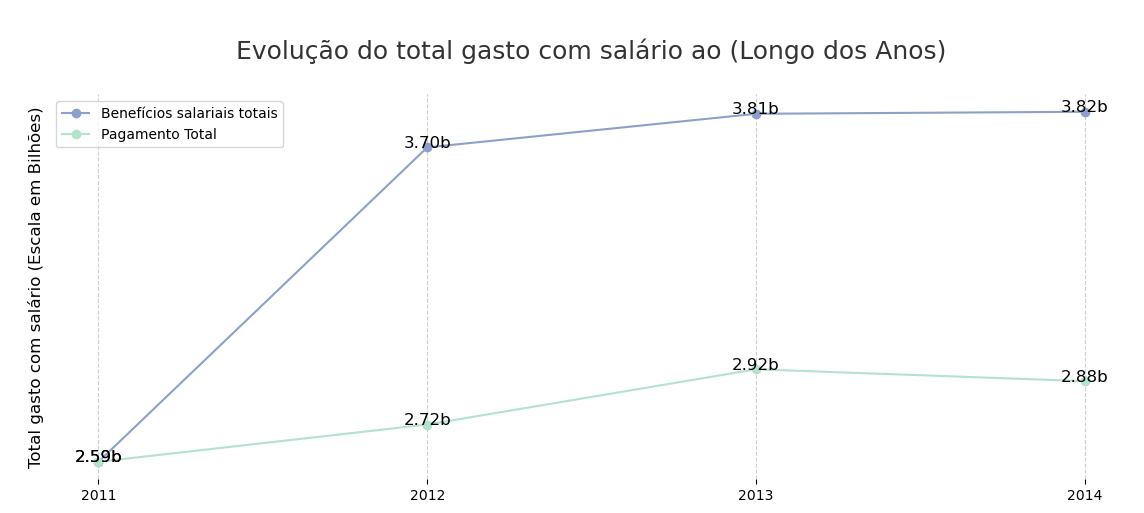

In [10]:
def exibir_grafico_linha(base,altura):
    '''#### Funcao posiciona cada valor em formato de bilhoes<br>
       
        for x, y in zip(base, altura):
        
            valor_bilhoes = y / 1e9
            ax.text(x, y + 300, f"{valor_bilhoes:,.2f}b".replace(',','.'),
            ha='center',
            fontsize=12,color='black')
'''
    for x, y in zip(base, altura):

        valor_bilhoes = y / 1e9
        ax.text(x, y + 150, f"{valor_bilhoes:,.2f}b".replace(',','.'), ha='center', fontsize=12,color='black')


tabela_salario = tabela.groupby('Year')[['TotalPay','TotalPayBenefits']].sum()
pagamento_total = tabela_salario['TotalPay'].values
beneficios_salariais_totais = tabela_salario['TotalPayBenefits'].values


fig, ax = plt.subplots(figsize=(14,5))
ax.plot(year, beneficios_salariais_totais, marker='o', color=paletas[2], label="Benefícios salariais totais")
ax.plot(year, pagamento_total, marker='o', label="Pagamento Total")


# Adicionando rótulos diretamente nos pontos dos graficos de linha
exibir_grafico_linha(year,pagamento_total)
exibir_grafico_linha(year,beneficios_salariais_totais)

# Configurações
ax.set_title("\nEvolução do total gasto com salário ao (Longo dos Anos)\n", fontsize=18,alpha=0.8)

# Dividi os valores de x com year[len(year)//4] - 0.5
# Ajustei a altura de y com max(pagamento_total) - 150

# ax.text(year[len(year)//4] - 0.5, max(pagamento_total) - 150,"O time aumentou em {:.1%}.▲".format(crescimento),fontsize=14,color=paletas[2],ha='center')
ax.set_ylabel("\nTotal gasto com salário (Escala em Bilhões)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])
ax.legend()
plt.show()


**Gasto Total com Salários:**

* **Aumento:** O gasto total com salários aumentou significativamente ao longo dos anos, com uma pequena desaceleração nos anos de 2013 e 2014. Apesar de estar em linha com o crescimento do número de funcionários e dos salários médios como já mencionado, essa desaceleração não impactou tanto o gasto total com salários, que saiu de uma linha crescente linear correlativa. Isso indica uma tendência de estabilização e pode apontar para um cenário mais padrão e saudável para as finanças.

Ou tiveram demissões ou reajustes nos cargos de maiores salários. Deve ser por esse motivo que, mesmo com o aumento no número de funcionários, essa soma não foi impactada.


##### 5. Prever, nesse ritmo, a evolução dos salários médios nos próximos 5 anos.

In [11]:
print(tabela_media)

         TotalPay TotalPayBenefits
Year                              
2011  R$71.744,10      R$71.744,10
2012  R$74.113,26     R$100.553,23
2013  R$77.611,44     R$101.440,52
2014  R$75.463,92     R$100.250,92


In [40]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split

# Modelos de IA
# obs: Usei 'Regression' pois estou em busca de prever um valor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

### Construção modelo de previsao

- Para fazer esse modelo de previsao decidi escolher algumas colunas de minha com bastante cuidado pois tenho ao todo 148.000 MIL linhas e nao queria perder já que é pouco esses dados.




In [30]:
#  é importante usar .copy() para evitar alterações indesejadas no tabela_salarios
tabela_para_previsao = tabela_salarios[['JobTitle', 'BasePay', 'OtherPay', 
                                        'Benefits', 'TotalPay', 'TotalPayBenefits', 'Year']].copy()

# Substituir valores 'NaN' em 'Benefits' por 0
# O método fillna é ideal para lidar com valores ausentes (NaN) em colunas. 
# Ele substitui todos os NaN de forma eficiente.
tabela_para_previsao['Benefits'] = tabela_para_previsao['Benefits'].fillna(0)

# Remover valores vazios caso fique algum nan pendente
tabela_para_previsao = tabela_para_previsao.dropna()

- Uma das colunas para ver qual sera sua correlacao de impacto nos salarios foi 'Benefits' ela tem 36.000 linhas em branco e pensei é 24% da minha base entao tenho que pensar em algo em vez de perder esse insigth.

- Em vez de remover vou alterar de  'NaN' para '0.0' pois notei que o ano de 2011 os funcionarios não tiveram Benefits, ai nao vali apena perder um ano de analise.

In [31]:
# Exibir os primeiros registros
display(tabela_para_previsao.head())

,JobTitle,BasePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,400184.25,0.0,567595.43,567595.43,2011
1,CAPTAIN III (POLICE DEPARTMENT),155966.02,137811.38,0.0,538909.28,538909.28,2011
2,CAPTAIN III (POLICE DEPARTMENT),212739.13,16452.60,0.0,335279.91,335279.91,2011
3,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,198306.90,0.0,332343.61,332343.61,2011
4,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,182234.59,0.0,326373.19,326373.19,2011


In [32]:
tabela_para_previsao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148045 entries, 0 to 148653
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   JobTitle          148045 non-null  object 
 1   BasePay           148045 non-null  float64
 2   OtherPay          148045 non-null  float64
 3   Benefits          148045 non-null  float64
 4   TotalPay          148045 non-null  float64
 5   TotalPayBenefits  148045 non-null  float64
 6   Year              148045 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 9.0+ MB


- Agora que já resolvi os valores nulos preciso olhar mais de perto as colunas **JobTitle** e **Year**.

- As duas precisa ser classificadas com algum valor que faça sentido para meu modelo, exemplo: o valor do ano de 2012, pro modelo isso soa como 2.012 mil e não faz sentido nenhum, preciso agrupar os valores que se repeti e criando assim uma lista de ocorrencias inteiras assim [1,2,3,4,4,2,2,2...].

- Usarei o factorize() que tem esse proposito de classificar valores que se repeti em um array.

In [33]:
# Classificando e modificando a mesma coluna

'''JobTitle'''
tabela_para_previsao['JobTitle'] = pd.factorize(tabela_para_previsao['JobTitle'])[0]  # passa um np.ndarray
tabela_para_previsao['JobTitle'] += 1  # para começar com o número 1

'''Year'''
tabela_para_previsao['Year'] = pd.factorize(tabela_para_previsao['Year'])[0]  # passa um np.ndarray
tabela_para_previsao['Year'] += 1  # para começar com o número 1

display(tabela_para_previsao.head())

,JobTitle,BasePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,1,167411.18,400184.25,0.0,567595.43,567595.43,1
1,2,155966.02,137811.38,0.0,538909.28,538909.28,1
2,2,212739.13,16452.60,0.0,335279.91,335279.91,1
3,3,77916.00,198306.90,0.0,332343.61,332343.61,1
4,4,134401.60,182234.59,0.0,326373.19,326373.19,1


In [34]:
tabela_para_previsao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148045 entries, 0 to 148653
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   JobTitle          148045 non-null  int64  
 1   BasePay           148045 non-null  float64
 2   OtherPay          148045 non-null  float64
 3   Benefits          148045 non-null  float64
 4   TotalPay          148045 non-null  float64
 5   TotalPayBenefits  148045 non-null  float64
 6   Year              148045 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 9.0 MB


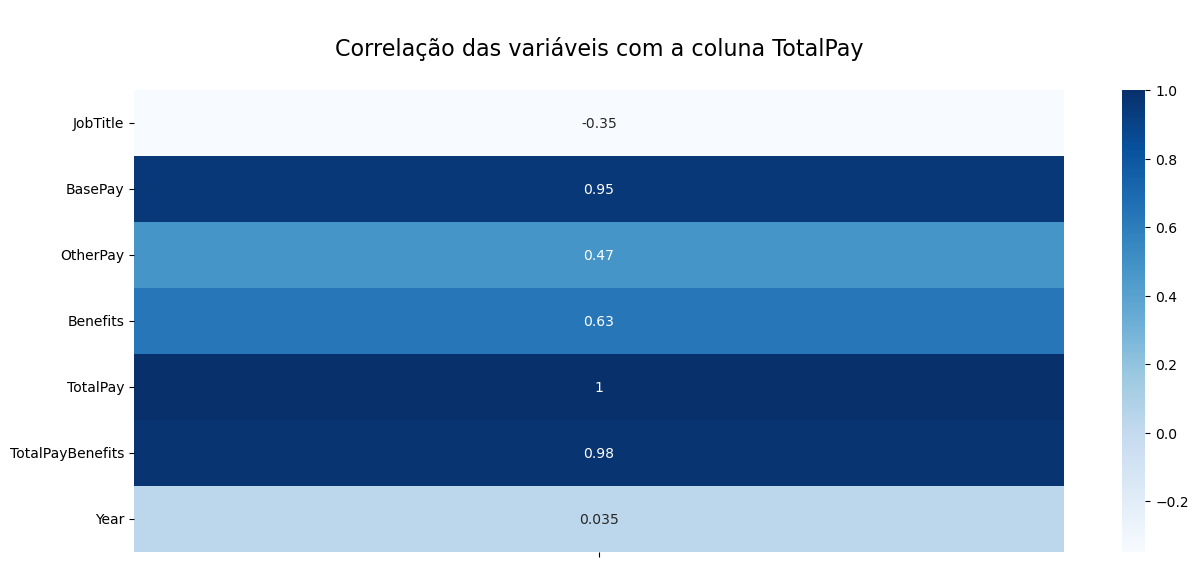

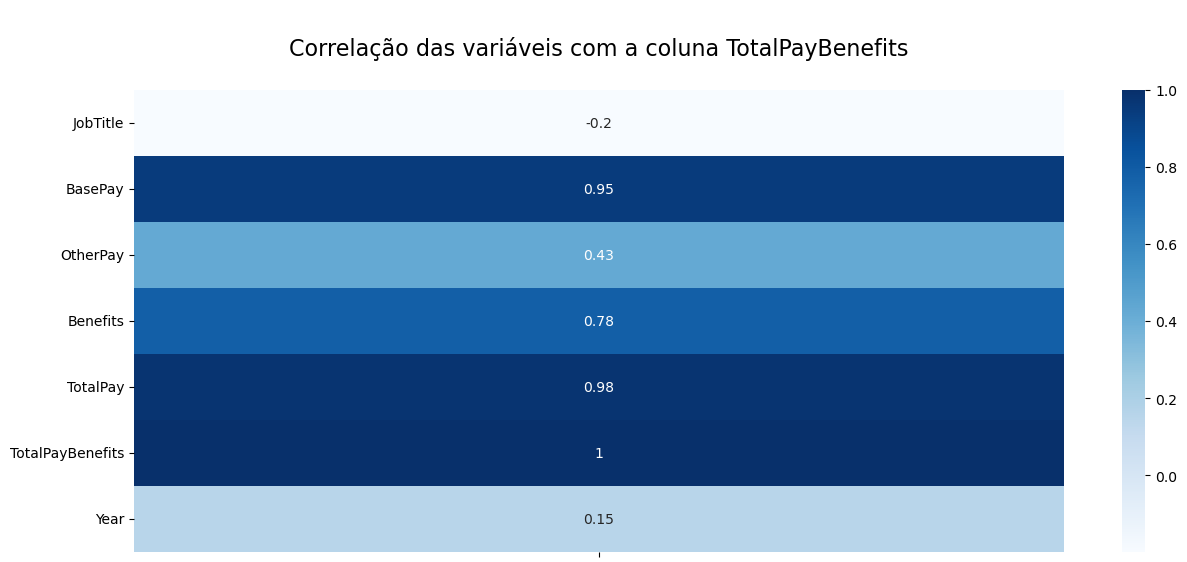

In [37]:
def grafico_corr(df,coluna):
    plt.figure(figsize=(15,6))
    corr = sns.heatmap(df.corr()[[f'{coluna}']], 
                annot=True, 
                cmap='Blues')

    corr.set_title(f'\nCorrelação das variáveis ​​com a coluna {coluna}\n',
                   fontdict={'fontsize':16})
    corr.set_xticklabels([]) # retirar os tiks
    plt.show()

grafico_corr(tabela_para_previsao,'TotalPay')
grafico_corr(tabela_para_previsao,'TotalPayBenefits')

- Nossa que lindo as correlacoes estao ao meu favor, e um ponto a destacar tive uma surpresa com a cargo e o ano achei que ambos influenciava mais nos salarios e não é bem isso que aconteceu.

In [42]:
import time
valores_previsao = []

def avaliar_modelo(tempo,nome_modelo,y_teste,previsao):
    
    r2 = r2_score(y_teste, previsao) 
    RSME = np.sqrt(mean_absolute_error(y_teste, previsao))
    return print(f'Tempo: {tempo}\nModelo: {nome_modelo}\nR²: {r2:.2%}\nRSME: {RSME:.2f}\n')

def exibir_resultados_modelos(dic, xteste, yprever):
    
    global valores_previsao
    

    for nome_modelo, modelo in dic.items():

        inicio_teste = time.time()
        previsao = modelo.predict(xteste) #Testar
        fim_teste = time.time()

        avaliar_modelo(f'{fim_teste - inicio_teste:.1f}s',nome_modelo, yprever, previsao)
        valores_previsao.append(previsao)

def grafico_exibir_modelo(teste,modelo = None):
    tabela_auxiliar = pd.DataFrame()
    tabela_auxiliar["Valores Teste"] = teste

    if modelo:
        tabela_auxiliar["Arvore Decisão Extra"] = modelo[0]
        tabela_auxiliar["Floresta Decisão"] = modelo[1]
        tabela_auxiliar["Regressao Linear"] = modelo[2]
        tabela_auxiliar["Regressor Arvore Decisão"] = modelo[3]

    plt.figure(figsize=(15,6))
    #cria
    
    linha = sns.lineplot(data=tabela_auxiliar)

    if modelo:
        linha.set_title('\nVisualização de dados relacionais: impacto da variação de uma variável contínua sobre outra\n',fontdict={'fontsize':16})
    else:
        linha.set_title('\nVisualização de Valores Teste: impacto de sua variação\n',fontdict={'fontsize':16})
    
    linha.tick_params(grid_alpha=0)
    linha.set_yticklabels([]) # retirar os tiks
    linha.set_xticklabels([]) # retirar os tiks
    #exibi
    plt.show()

def grafico_exibir_modelo_final(teste,modelo = None):
    tabela_auxiliar = pd.DataFrame()
    tabela_auxiliar["Valores Teste"] = teste

    if modelo:
        tabela_auxiliar["Arvore Decisão Extra"] = modelo[0]
        tabela_auxiliar["Floresta Decisão"] = modelo[1]

    plt.figure(figsize=(15,6))
    #cria
    
    linha = sns.lineplot(data=tabela_auxiliar)

    if modelo:
        linha.set_title('\nVisualização de dados relacionais: impacto da variação de uma variável contínua sobre outra\n',fontdict={'fontsize':16})
    else:
        linha.set_title('\nVisualização de Valores Teste: impacto de sua variação\n',fontdict={'fontsize':16})
    
    linha.tick_params(grid_alpha=0)
    linha.set_yticklabels([]) # retirar os tiks
    linha.set_xticklabels([]) # retirar os tiks
    #exibi
    plt.show()

In [43]:
tabela_copia = tabela_para_previsao.copy()


# Criando meu y e x para treinar
y = tabela_copia['TotalPay']# Separ a coluna que pretendo prever
x = tabela_copia.drop('TotalPay',axis=1)# Retirar a coluna que pretendo prever 

''' random_state=1 faz com que a divisao aleatoria seja sempre a mesma '''
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

# Instanciar os modelos
modelo_arvores_extras = ExtraTreesRegressor() 
modelo_floresta = RandomForestRegressor()
modelo_linear = LinearRegression()
modelo_decision_tree = DecisionTreeRegressor()

# Adicionar os modelos ao dicionário
modelos = {
    'ArvoresExtras': modelo_arvores_extras,
    'Floresta': modelo_floresta,
    'Linear': modelo_linear,
    'DecisionTree': modelo_decision_tree
}

# Treinar os modelos
for nome_modelo, modelo in modelos.items():
    modelo.fit(X_train, y_train)


In [45]:
exibir_resultados_modelos(modelos, X_test, y_test)
# grafico_exibir_modelo(y_test)
# grafico_exibir_modelo(y_test, valores_previsao)




Tempo: 5.3s
Modelo: ArvoresExtras
R²: 99.98%
RSME: 11.67

Tempo: 4.7s
Modelo: Floresta
R²: 99.97%
RSME: 14.64

Tempo: 0.0s
Modelo: Linear
R²: 100.00%
RSME: 0.00

Tempo: 0.1s
Modelo: DecisionTree
R²: 99.91%
RSME: 18.36



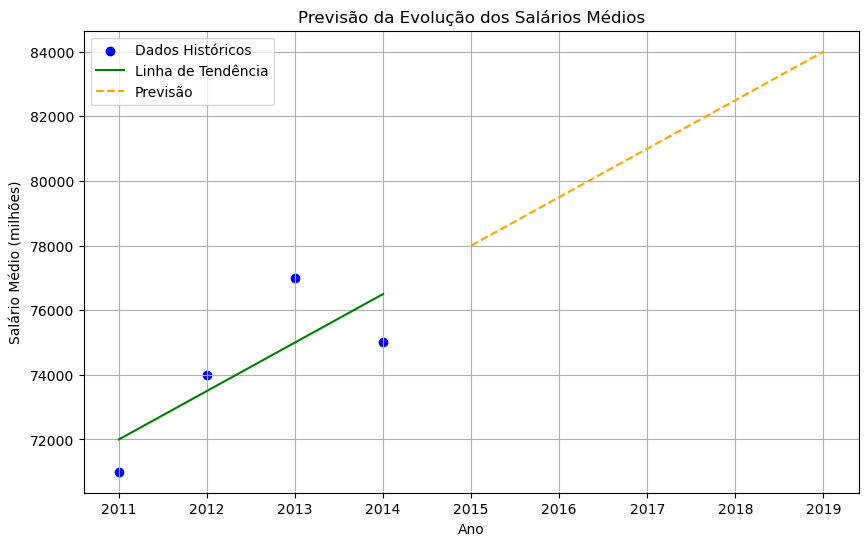

Ano: 2015, Salário Médio Previsto: R$78,000.00 milhões
Ano: 2016, Salário Médio Previsto: R$79,500.00 milhões
Ano: 2017, Salário Médio Previsto: R$81,000.00 milhões
Ano: 2018, Salário Médio Previsto: R$82,500.00 milhões
Ano: 2019, Salário Médio Previsto: R$84,000.00 milhões


In [15]:


# Dados históricos (ano e salários médios, em milhões por exemplo)
anos = np.array([2011, 2012, 2013, 2014]).reshape(-1, 1)
TotalPay = np.array([71000, 74000, 77000, 75000])  # Exemplos em milhões
TotalPayBenefits = np.array([71000, 100000, 101000, 100000])  # Exemplos em milhões

# Treinando o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(anos, TotalPay)

# Previsões para os próximos 5 anos
anos_futuros = np.array([2015,2016,2017,2018,2019]).reshape(-1, 1)
previsoes = modelo.predict(anos_futuros)

# Visualização
plt.figure(figsize=(10, 6))
plt.scatter(anos, TotalPay, color='blue', label='Dados Históricos')
plt.plot(anos, modelo.predict(anos), color='green', label='Linha de Tendência')
plt.plot(anos_futuros, previsoes, color='orange', linestyle='--', label='Previsão')
plt.title('Previsão da Evolução dos Salários Médios')
plt.xlabel('Ano')
plt.ylabel('Salário Médio (milhões)')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo os resultados
for ano, salario in zip(anos_futuros.flatten(), previsoes):
    print(f"Ano: {ano}, Salário Médio Previsto: R${salario:,.2f} milhões")


## Análise da Evolução Salarial ao Longo dos Anos

In [12]:
'''
**Prezados,**

Segue análise dos gráficos de evolução salarial, com o intuito de fornecer uma visão geral da situação salarial da empresa nos últimos anos:

### **Tendência Geral:**


### **Composição Salarial:**

* **Benefícios:** A parcela dos benefícios salariais na remuneração total manteve-se relativamente estável ao longo dos anos, indicando que a empresa mantém uma política de benefícios consistente.

### **Desempenho por Cargo:**


### **Gasto Total com Salários:**

* **Aumento:** O gasto total com salários aumentou significativamente ao longo dos anos, em linha com o crescimento do número de funcionários e dos salários médios.

### **Considerações Finais:**

* **Política salarial:** A empresa parece ter uma política salarial competitiva, com reajustes regulares e uma oferta de benefícios atrativa.
* **Impacto no orçamento:** O crescimento contínuo dos gastos com salários deve ser monitorado de perto, pois pode ter um impacto significativo no orçamento da empresa.
* **Análise mais detalhada:** Para uma análise mais aprofundada, seria interessante cruzar esses dados com outros indicadores, como desempenho individual e da empresa, para identificar possíveis correlações.

**Recomendações:**

* **Análise por área:** Realizar uma análise mais detalhada da evolução salarial por área, para identificar possíveis disparidades e oportunidades de ajuste.
* **Comparação com o mercado:** Comparar os salários da empresa com os salários praticados no mercado para as mesmas funções e regiões, a fim de garantir a competitividade.
* **Revisão da política de benefícios:** Revisar periodicamente a política de benefícios para garantir que ela continue sendo atrativa e alinhada com as necessidades dos colaboradores.

**Em resumo,** os dados apresentados indicam uma evolução positiva da remuneração dos colaboradores da empresa. No entanto, é importante continuar monitorando essa tendência e realizar ajustes na política salarial conforme necessário, a fim de garantir a sustentabilidade financeira da empresa e a satisfação dos colaboradores.

**Atenciosamente,**
[Seu Nome]
[Seu Cargo]


'''

'\n**Prezados,**\n\nSegue análise dos gráficos de evolução salarial, com o intuito de fornecer uma visão geral da situação salarial da empresa nos últimos anos:\n\n### **Tendência Geral:**\n\n\n### **Composição Salarial:**\n\n* **Benefícios:** A parcela dos benefícios salariais na remuneração total manteve-se relativamente estável ao longo dos anos, indicando que a empresa mantém uma política de benefícios consistente.\n\n### **Desempenho por Cargo:**\n\n\n### **Gasto Total com Salários:**\n\n* **Aumento:** O gasto total com salários aumentou significativamente ao longo dos anos, em linha com o crescimento do número de funcionários e dos salários médios.\n\n### **Considerações Finais:**\n\n* **Política salarial:** A empresa parece ter uma política salarial competitiva, com reajustes regulares e uma oferta de benefícios atrativa.\n* **Impacto no orçamento:** O crescimento contínuo dos gastos com salários deve ser monitorado de perto, pois pode ter um impacto significativo no orçamento d